## Topographic Complexity: Mexican Hat Wavelet Analysis  
### *[Base Version]*

Two-dimensional continuous wavelet transform (2D-CWT) with a Mexican Hat wevalet has been applied to measure the topographic complexity (i.e., surface roughness) of a land surface. Such method quanitfy the wavelet-based curvature of the surface, which has been proposed to be a effective geomorphic metric for relative age dating of deep-seated landslide deposits, allowing a quick assessment of landslide freqency and spatiotemporal pattern over a large scale area.

The original MATLAB code was developed by Dr. Adam M. Booth (Portland State Univeristy) and used in Booth et al. (2009) and Both et al. (2017). This MATLAB code was later revised and adapted by Dr. Sean R. LaHusen (Univeristy of Washington) and Erich N. Herzig (Univeristy of Washington) in their research (e.g., LaHusen et al., 2020; Herzig et al., 2023).

Since November 2023, Dr. Larry Syu-Heng Lai (Univeristy of Washington) translated this code into a open-source Python version with continous optimizations. The current codes have the capability to automoatically detect the grid spacing ($\Delta$) and the unit of XYZ direction of the input Digital Elevation Model (DEM) raster and compute the 2D-CWT results with the adequate wavelet scale factor ($s$) at an designated Mexican Hat wavelet ($\lambda$).

To use this code, please cite the Zenodo repository that hosts the latest release of this code: 
* Lai, L. S.-H. (2024). pyTopoComplexity. Zenodo. https://doi.org/10.5281/zenodo.10065283
* Github repository: https://github.com/LarrySHLai/pyTopoComlexity

### Import packages

In [9]:
import os
import numpy as np
from scipy.signal import convolve2d
from scipy.signal import fftconvolve
import rasterio
import sys
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

### Define the 2D-CWT function

The following equations are modified from Booth et al. (2009) and Torrence and Compo (1998).

The 2D-CWT provides information regarding how amplitude is distributed over spatial frequency at each position in the data by transforming spatial data into position-frequency space. The 2D-CWT is calculated by a convolution of the elevation $z$ and a wavelet family $\psi$, with a wavelet scale parameter $s$ at every location ($x$, $y$). Thus the wavelet coefficient $C(s,x,y)$ provides a measure of how well the wavelet $\psi$ matches the data $z$ at each node/grid. When $s$ is large, $\psi$ is spread out and takes into account long wavelength features of $z$; when $s$ is small, $\psi$ is more localized in space and sensitive to fine-scale features of $z$. Here we use 2D Mexican hat wavelet function to describe $\psi$. The Mexican hat is proportional to the second derivative of a Gaussian envelope, and it has a wavelength ($\lambda$) which is dependent on the grid spacing ($\Delta$) of the input raster. The $\psi$ here has been scaled to the wavelet scale parameter $s$ and the grid spacing $\Delta$ so that the wavelet coefficient $C$ is equal to curvature. 

$$
C (s, x, y) = \Delta^2 \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} z(x, y) \psi \left( x, y \right) dx \, dy
$$

$$
\psi = − \frac{1}{\pi(s\Delta)^4}(1-\frac{𝑥^2+𝑦^2}{2s^2})e^{(-\frac{𝑥^2+𝑦^2}{2s^2})}
\:\:\:\:\:\:\:\:\:
\lambda=\frac{2\pi s}{\sqrt{5/2}}\Delta
$$

#### Operating the convolution by the numpy packages

The conventional way is using <code>convolve2d</code> - Much slower method

A optimized way is using <code>fftconvolve</code> Fast Fourier Transform (FFT) - Much faster method


***Notes:***
If the input DEM raster include grids that contain uncommonly/errorenously created no-data values, the <code>fftconvolve</code> package used in the <code>conv2_mexh</code> function will return empty result in that chunk with an error message *"RuntimeWarning: invalid value encountered in multiply ret = ifft(sp1 * sp2, fshape, axes=axes)"*. The function will still proceed to process the rest of the chunks, resulting a raster with empty squares. In this case, users may switch to the conventional <code>convolve2d</code> convolution package in the <code>conv2_mexh</code>, which will significantlly increase the processing time.

In [10]:
def conv2_mexh(Z, s, Delta):
    # The kernel must be large enough for the wavelet to decay to ~0 at the edges.
    X, Y = np.meshgrid(np.arange(-8 * s, 8 * s + 1), np.arange(-8 * s, 8 * s + 1))

    # scaled psi equation. Units of [1/(m^4)]
    psi = (-1/(np.pi*(s * Delta)**4)) * (1 - (X**2 + Y**2)/(2 * s**2)) * np.exp(-(X**2 + Y**2)/(2* s**2))  

    # Calculating the wavelet coefficient C, multiplied by Delta^2. Units of [(m^2) x (m) x (1/(m^4)) = (1/m)]
    # 'same' mode is used to approximate the double integral. 
    #C = (Delta**2) * convolve2d(Z, psi, mode='same') #Slow conventional method
    C = (Delta**2) * fftconvolve(Z, psi, mode='same') #Fast Fourier Transform (FFT) method

    return C

### Set up the input and output file names and directories
The default assumes the input and output GeoTIFF rasters will be placed in the same directory - a subfolder named <code>'Example DEM'</code>

In [11]:
base_dir = os.getcwd()  #Change the directory of base folder as needed
base_dir = os.path.join(base_dir, 'Example DEM')

input_file = 'Ososlid2014_m_3ftgrid.tif'
output_file = 'Ososlid2014_m_3ftgrid_pymexhat.tif'

input_dir = os.path.join(base_dir, input_file)
output_dir = os.path.join(base_dir, output_file)

### Extract information from the input DEM raster
The following section is used to extract coordinate reference system (crs) information, which is critical to contrain the grid spacing $\Delta$ and wavelet scale $s$ 

In [12]:
with rasterio.open(input_dir) as src:
    transform = src.transform
    crs = src.crs

    # Print the CRS information
    print(f"CRS as WKT: {crs.wkt}")
    print(f"CRS as EPSG code: {crs.to_epsg()}")
    print(f"X grid size: {transform[0]} [{crs.linear_units}]")
    print(f"Y grid size: {-transform[4]} [{crs.linear_units}]")

CRS as WKT: PROJCS["NAD83 / Washington South",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",45.3333333333333],PARAMETER["central_meridian",-120.5],PARAMETER["standard_parallel_1",47.3333333333333],PARAMETER["standard_parallel_2",45.8333333333333],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32149"]]
CRS as EPSG code: 32149
X grid size: 0.9144018125552492 [metre]
Y grid size: 0.9144018536585485 [metre]


### Define parameters
##### *Define the desired Mexican Hat Fourier wavelet $\lambda$ (in meters)*

In [13]:
Lambda = 15

##### *Derive the correct grid spacing $\Delta$ and wavelet scale $s$*

In [14]:
ft2mUS = 1200/3937 #US survey foot to meter conversion factor 
ft2mInt = 0.3048 #International foot to meter conversion factor 

with rasterio.open(input_dir) as src:
    transform = src.transform
    crs = src.crs

# Delta is the grid spacing (pixel size) of the input DEM raster. Unit in [m].
if any(unit in crs.linear_units.lower() for unit in ["metre".lower(), "meter".lower(), "meters".lower()]):
    print("Input grid size is in meters. No unit conversion is made")
    Delta = np.mean([transform[0], -transform[4]])
elif any(unit in crs.linear_units.lower() for unit in ["foot".lower(), "feet".lower(), "ft".lower()]):  
    if any(unit in crs.linear_units.lower() for unit in ["US".lower(), "United States".lower()]):
        print("Input grid size is in US survey feet. A unit conversion to meter is made")
        Delta = np.mean([transform[0] * ft2mUS, -transform[4] * ft2mUS])
    else: 
        print("Input grid size is in international feet. A unit conversion to meter is made")
        Delta = np.mean([transform[0] * ft2mInt, -transform[4] * ft2mInt])
else:
    print("WARNING: The code excution is stopped")
    print("The units of XY directions must be in feet or meters")
    print("Please reproject the raster into a suitable coordinates reference system")
    sys.exit()

# 's' is the scale of the wavelet [Unitless] 
s = (Lambda/Delta)*((5/2)**(1/2)/(2*np.pi))     # Torrence and Compo [1998]
# When Delta close to 1 meter, 's' aprox. mex-hat wavelength/4

print('Grid spacing "Delta" =', Delta, '[m]')
print('For a', Lambda, 'm Mexican Hat wavelet, ...')
print('the wavelet scale "s" =', s, '[]')

Input grid size is in meters. No unit conversion is made
Grid spacing "Delta" = 0.9144018331068988 [m]
For a 15 m Mexican Hat wavelet, ...
the wavelet scale "s" = 4.1280438983932415 []


### Executing the Mexican Hat convolution codes

Users may manually define the unit of the elevation ($z$). **The default assumes that the $z$ unit in the input DEM raster is the same as the unit in $x$ and $y$ directions** (e.g., XYZ in meters, XYZ in feet).

In [15]:
ft2mUS = 1200/3937 #US survey foot to meter conversion factor 
ft2mInt = 0.3048 #International foot to meter conversion factor 

start_time = time.time()  # Start timer

with rasterio.open(input_dir) as src:
    Z = src.read(1)
    Zunit = src.crs.linear_units   #assuming the Z unit is the same as the units of XY directions
    #Zunit = "metre"               #Manually define the elevation unit. Acceptable inputs: "metre", "meter", "meters", "foot", "feet", "ft", "US survey foot"

# Check the unit of Z and make unit conversion when needed
if any(unit in Zunit.lower() for unit in ["metre".lower(), "meter".lower()]):
    print("Input elevation is in meters. No unit conversion is made")
elif any(unit in Zunit.lower() for unit in ["foot".lower(), "feet".lower(), "ft".lower()]):  
    if any(unit in Zunit.lower() for unit in ["US".lower(), "United States".lower()]):
        print("Input elevation is in US survey feet. A unit conversion to meter is made")
        Z = Z * ft2mUS
    else:
        print("Input elevation is in international feet. A unit conversion to meter is made")
        Z = Z * ft2mInt
else:
    print("WARNING: The code excution is stopped")
    print("The unit of elevation 'z' must be in feet or meters")
    print("Please redefine the 'Zunit' parameter")
    sys.exit()

# Compute Mexican Hat 2D Continuous Wavelet Transform
C2 = conv2_mexh(Z, s, Delta)
result = np.abs(C2)

# Mask edge with NaN (no data) values to remove artifacts
cropedge = np.ceil(s * 4)
fringeval = int(cropedge)
result[:fringeval, :] = np.nan
result[:, :fringeval] = np.nan
result[-fringeval:, :] = np.nan
result[:, -fringeval:] = np.nan

# Write result to GeoTIFF
with rasterio.open(output_dir, 'w', driver='GTiff', height=Z.shape[0], 
                   width=Z.shape[1], count=1, compress='deflate',
                    bigtiff='IF_SAFER', dtype=Z.dtype, crs=crs, transform=transform) as dst:
    dst.write(result.astype(Z.dtype), 1)

end_time = time.time()  # Stop timer

print(f"The Mexican Hat convolution is done")
print(f"Execution time: {end_time - start_time:.6f} seconds")

Input elevation is in meters. No unit conversion is made
The Mexican Hat convolution is done
Execution time: 0.468450 seconds


### Display the result

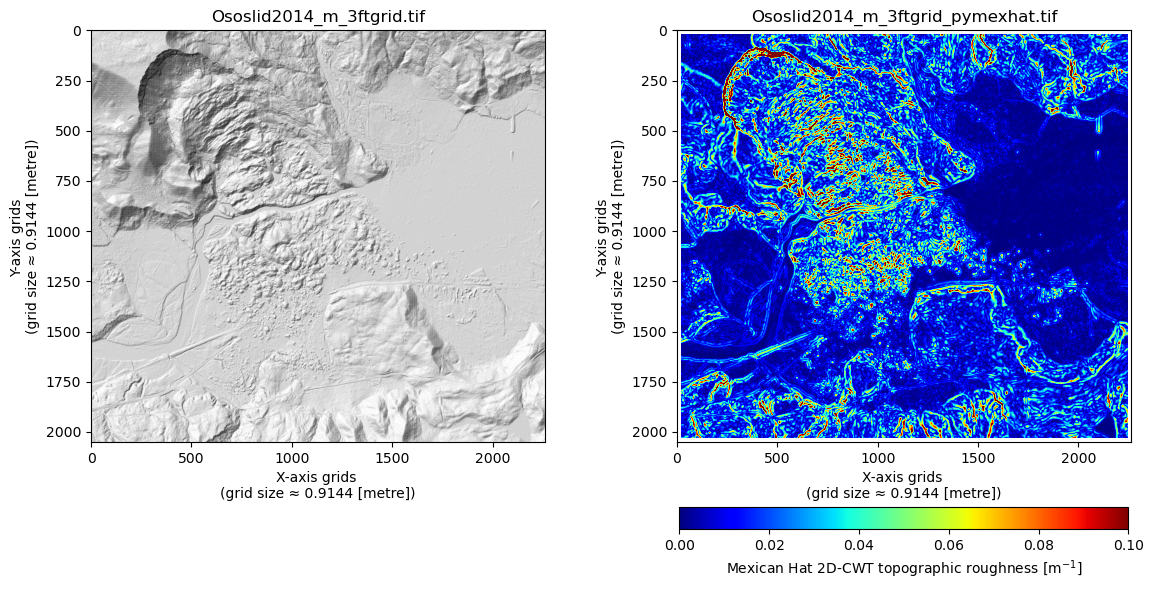

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the hillshade
ls = LightSource(azdeg=315, altdeg=45)
hs = axes[0].imshow(ls.hillshade(Z*2), cmap='gray') #2x vertical exaggeration for hillshade 
axes[0].set_title(input_file)
axes[0].set_xlabel(f'X-axis grids \n(grid size ≈ {round(transform[0],4)} [{crs.linear_units}])')
axes[0].set_ylabel(f'Y-axis grids \n(grid size ≈ {-round(transform[4],4)} [{crs.linear_units}])')
cbar1 = fig.colorbar(hs, ax=axes[0], orientation='horizontal', fraction=0.045, pad=0.13)
cbar1.ax.set_visible(False)

# Plot the 2D-CWT roughness
im = axes[1].imshow(result, cmap='jet')
im.set_clim(0, round(np.nanpercentile(result, 99), 2))  # Set the upperlimit to the 99th percentile to avoid exterem values
axes[1].set_title(output_file)
axes[1].set_xlabel(f'X-axis grids \n(grid size ≈ {round(transform[0],4)} [{crs.linear_units}])')
axes[1].set_ylabel(f'Y-axis grids \n(grid size ≈ {-round(transform[4],4)} [{crs.linear_units}])')
cbar2 = fig.colorbar(im, ax=axes[1], orientation='horizontal', fraction=0.045, pad=0.13)
cbar2.set_label('Mexican Hat 2D-CWT topographic roughness [m$^{-1}$]')
plt.tight_layout()
plt.show()

### References:  
##### Journal Articles: 
* Booth, A.M., Roering, J.J., Perron, J.T., 2009. Automated landslide mapping using spectral analysis and high-resolution topographic data: Puget Sound lowlands, Washington, and Portland Hills, Oregon. Geomorphology 109, 132-147. https://doi.org/10.1016/j.geomorph.2009.02.027  
* Booth, A.M., LaHusen, S.R., Duvall, A.R., Montgomery, D.R., 2017. Holocene history of deep-seated landsliding in the North Fork Stillaguamish River valley from surface roughness analysis, radiocarbon dating, and numerical landscape evolution modeling. Journal of Geophysical Research: Earth Surface 122, 456-472. https://doi.org/10.1002/2016JF003934  
* LaHusen, S.R., Duvall, A.R., Booth, A.M., Grant, A., Mishkin, B.A., Montgomery, D.R., Struble, W., Roering, J.J., Wartman, J., 2020. Rainfall triggers more deep-seated landslides than Cascadia earthquakes in the Oregon Coast Range, USA. Science Advances 6, eaba6790. https://doi.org/10.1126/sciadv.aba6790  
* Herzig, E.N., Duvall, A.R., Booth, A.R., Stone, I., Wirth, E., LaHusen, S.R., Wartman, J., Grant, A., 2023. Evidence of Seattle Fault Earthquakes from Patterns in Deep‐Seated Landslides. Bulletin of the Seismological Society of America. https://doi.org/10.1785/0120230079 
* Torrence, C., Compo, G.P., 1998. A practical guide to wavelet analysis. Bulletin of the American Meteorological Society 79 (1), 61–78.

##### Digital Elevation Model (DEM) Examples:
* Washington Geological Survey, 2023. 'Stillaguamish 2014' and 'Snohoco Hazel 2006' projects [lidar data]: originally contracted by Washington State Department of Transportation (WSDOT). [accessed April 4, 2024, at http://lidarportal.dnr.wa.gov]